# Описание проекта, постановка задачи

**Данные**

Табличка содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений. 

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

**Задача**

Нужно разделить пользователей по следующим метрикам:

1. retention rate,
2. время, проведённое в приложении, 
3. частота действий, 
4. конверсия в целевое действие — просмотр контактов.

- **Провести исследовательский анализ данных**
- **Сегментировать пользователей на основе действий**
- **Проверить статистические гипотезы:**

    1.Гипотеза №1: Группы Yandex и Google демонстрируют разную конверсию в просмотры контактов
    
    2.Гипотеза № 2: Количество времени, проведенное в приложении, коррелирует с конверсией в просмотры контактов

Ссылка на презентацию:
   https://disk.yandex.ru/i/MNMOZnHD-x2LHA 
   
Ссылка на дашборд:


## Изучение базы данных. Предобработка данных.

### Импорт библиотек и загрузка данных

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as st
import math as mth
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display_html
pd.set_option('display.max_columns', 30)
pd.set_option("display.float_format", "{:.3f}".format)
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
dt = datetime.datetime.now()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
# Загружаем данные
data = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')


### Первичная диагностика данных

In [3]:
data.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [4]:
sources.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Пропусков в данных не обнаружено. Требуется привести названия столбцов к хорошему синтаксису и преобразовать столбец event.time в нужный формат. 

### Приведение названий столбцов к единому синтаксису, преобразование временного формата, поиск дубликатов

In [6]:
# Переименуем столбцы
data.columns = data.columns.str.replace('.','_')
sources.columns = sources.columns.str.replace('.','_')
sources.rename(columns={'userId': 'user_id'}, inplace=True)

data.head()

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [7]:
sources.head()

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [8]:
# Поиск дубликатов
data.duplicated().sum()

0

Столбцы переименовали, дубликатов не обнаружено. 

### Объединение таблиц, преобразование временного формата

In [9]:
# Объединяем две таблички 
data_merged= data.merge(sources, on='user_id', how='left')

# Преобразовываем временной формат
data_merged['event_time']=pd.to_datetime(data_merged['event_time'], format ='%Y-%m-%d %H:%M:%S')
data_merged['event_time'] = data_merged['event_time'].dt.round('S')
data_merged['dt'] = pd.to_datetime(data_merged['event_time']).dt.date
data_merged['dt'] = pd.to_datetime(data_merged['dt'], format='%Y-%m-%d')
data_merged['dt'] = data_merged['dt'].dt.tz_localize(None)
data_merged['dt'] = data_merged['dt'].dt.date
data_merged

,event_time,event_name,user_id,source,dt
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07
...,...,...,...,...,...
74192,2019-11-03 23:53:30,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03
74193,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03
74194,2019-11-03 23:56:57,search_1,20850c8f-4135-4059-b13b-198d3ac59902,google,2019-11-03
74195,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03


In [10]:
# Сортируем датасет по двум столбцам для дальнейшего корректного выделения сессий
data_merged.sort_values(['user_id','event_name'])

,event_time,event_name,user_id,source,dt
6541,2019-10-09 18:33:56,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-09
6546,2019-10-09 18:35:28,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-09
36419,2019-10-21 19:53:39,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-21
36430,2019-10-21 19:56:49,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-21
37556,2019-10-22 11:18:15,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-22
...,...,...,...,...,...
72579,2019-11-03 15:50:56,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-11-03
72584,2019-11-03 15:51:24,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-11-03
72684,2019-11-03 16:07:41,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-11-03
72688,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-11-03


In [11]:
data_merged['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

Два типа событий contacts_show и show_contacts - это одно и то же событие, нужно объединить данные.Также можно объединить типы поисков. 

In [12]:
# Объединяем события показа контактов
data_merged.loc[data_merged['event_name']=='show_contacts', 'event_name'] = 'contacts_show'

In [13]:
# Пишем функцию для объединения поисков
def search_all(x):
    if x in ['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7']:
        return 'search'
    return x

In [14]:
data_merged['event_name_mod'] = data_merged['event_name'].apply(search_all)
data_merged['event_name_mod'].value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name_mod, dtype: int64

In [15]:
data_merged = data_merged.drop(['event_name'], axis=1)

In [16]:
data_merged.rename(columns={'event_name_mod': 'event_name'}, inplace=True)
data_merged['event_name'].value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

In [17]:
# добавляем колонку event_date

data_merged['event_date'] = pd.DatetimeIndex(data['event_time']).date.astype('datetime64[ns]')


In [18]:
# добавляем колонку week_day

data_merged['week_day'] = data_merged['event_date'].dt.weekday

Теперь данные выглядят корректно

**Вывод**: Данные представлены в двух таблицах: data и sources. Обе таблички содержат колонки с уникальным номером пользователя, в качестве преобразования названия колонок приведены к единому стандарту написания. 
Обе таблицы были объединены  по ключу уникального номера пользователя. Немного поработали над временным форматом для облегчения дальнейшего анализа: данные колонки event_time приведены к типу datetime64[ns], добавлены колонки event_date, dt, данные приведены к типу datetime64[ns], добавлена колонка week_day.
Пропущенные значения не выявлены, зеркально записанные данные (show_contacts и contacs_show) объединены под единой записью contacts_show.

## Исследовательский анализ EDA

###  Изучение распределение событий по дням

In [19]:
# Для начала, посмотрим на минимальную и максимальную даты в датасете.
print(f'Время первого события {data_merged.event_date.min()}')
print(f'Время последнего события {data_merged.event_date.max()}')     

Время первого события 2019-10-07 00:00:00
Время последнего события 2019-11-03 00:00:00


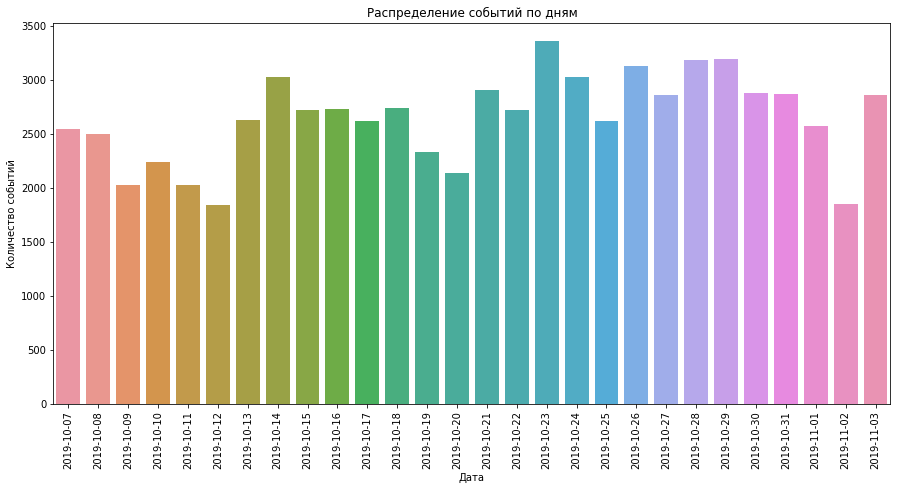

In [20]:
# Визуализируем распределение 
day_distribution = data_merged.groupby('dt')[['event_name']].count().reset_index()

plt.figure(figsize = (15,7))
sns.barplot(x='dt', y='event_name', data=day_distribution)
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение событий по дням')
plt.show()

**Вывод** :События по всему периоду сбора данных распределены равномерно, аномальных выбросов не обнаружено.

### Распределение событий по пользователям

In [21]:
# Выясним число уникальных пользователей
data_merged.user_id.nunique()

4293

Количество уникальных пользователей совпадает с размером таблицы sources.

In [22]:
# группируем данные по пользователю и считаем количество событий
user_events_count = data_merged.groupby('user_id')[['event_name']].count().reset_index()
print(f"Количество пользователей, совершивших лишь одно действие: {len(user_events_count[user_events_count['event_name'] == 1])}")
print(user_events_count.describe(percentiles=[0.05, 1/4, 1/2, 0.90, 0.95, 0.99]))

Количество пользователей, совершивших лишь одно действие: 65
       event_name
count    4293.000
mean       17.283
std        29.131
min         1.000
5%          3.000
25%         5.000
50%         9.000
90%        36.000
95%        59.000
99%       132.000
max       478.000


In [23]:
# Исключим пользователей с однимм действием из анализа, признав их выбросами.
drop_user = list(user_events_count[user_events_count['event_name'] == 1]['user_id'].unique())
data_merged = data_merged.query('user_id not in @drop_user')

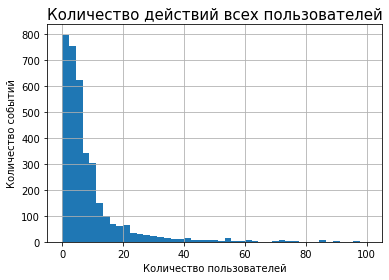

In [24]:
# выводим статистическую информацию по кол-ву действий всех пользователей
user_event = data_merged.query('event_name !="tips_show"').groupby(['user_id']).agg({'event_name':'count'}).sort_values(by='event_name', ascending=False).reset_index()
user_event['event_name'].hist(bins=45, range=(0,100)), user_event.describe(), user_event['event_name'].quantile(0.95), user_event['event_name'].quantile(0.05)
plt.title('Количество действий всех пользователей', fontsize=15)
plt.ylabel('Количество событий', fontsize=10)
plt.xlabel('Количество пользователей', fontsize=10)
plt.show()

In [25]:
# Проверим с какого источника, пользователь чаще устанавливает приложение
data_merged.groupby('source')['user_id'].count().sort_values(ascending=False)

source
yandex    34257
google    20433
other     19442
Name: user_id, dtype: int64

**Вывод**: Итого 65 пользователей совершили всего одно действие, среднее количество действий - 17, медианное - 9, самые активные пользователи приложения совершили более 60 действий. Также отмечено, что количество событий пользователя и количество различных действий отличаются. Мы исключили пользователей всего с одним действием, как несущественных для проведения анализа. Также мы убрали tips_show - это автоматическое действие, оно нам не нужно.
Самые часто совершаемые действия:
map - 1 456 клиент открыл карту объявлений
photos_show - 1 095 клиентов просмотрели фотографии в объявлениях
contacts_show - 981 клиент просмотрел контакты, т.е. совершил целевое действие
search_1 - 787 клиентов осуществили поиск 1.
Также мы выяснили, что пользователи, пришедшие с поисковой системы Яндекс, устанавливают приложение чаще.

### Выделение сессий

За длительность сессии взята  разница между временем осуществления первого действия и последнего действия в рамках одного календарного дня на уровне уникального пользователя.

In [26]:
# создаем таблицу длительности сессий

# создаем таблицу максимальных значений времени осуществления действия униканым пользователем в рамках одного дня
session_max = data_merged.groupby(['user_id', 'event_date'])['event_time'].agg('max').reset_index()

# создаем таблицу минимальных значений времени осуществления действия униканым пользователем в рамках одного дня
session_min = data_merged.groupby(['user_id', 'event_date'])['event_time'].agg('min').reset_index()

# объединяем таблицы на уровне уникального пользователя и дня осуществления действий
session_duration = session_max.merge(session_min, on = ['user_id', 'event_date'], how = 'left')\
.rename(columns = {'event_time_x':'event_time_max', 'event_time_y':'event_time_min'})

# создаем колонку с расчетом разницы между максимальными и минимальными значениями осуществления действий
# одним уникальным пользователейм в один день
session_duration['session_duration'] = (session_duration['event_time_max'] - session_duration['event_time_min']).dt.seconds


display(session_duration.head())

,user_id,event_date,event_time_max,event_time_min,session_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:49:42,2019-10-07 13:39:46,596
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:42:23,2019-10-09 18:33:56,507
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 20:07:30,2019-10-21 19:52:31,899
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:30:53,2019-10-22 11:18:15,758
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:59:55,2019-10-19 21:34:34,1521


In [27]:
# Смотрим данные о длительности сессий

session_duration['session_duration'].describe()

count    7752.000
mean     5023.768
std     11448.659
min         0.000
25%       158.750
50%       726.000
75%      2974.250
max     85049.000
Name: session_duration, dtype: float64

In [28]:
# Смотрим информацию о количестве сессий по длительности

display(session_duration['session_duration']\
        .value_counts()\
        .to_frame()\
        .reset_index()\
        .rename(columns={'index':'Длительность сессии', 'session_duration':'Количество сессий'})
        .sort_values(by='Длительность сессии', ascending=False).T)

,2933,1368,2228,3608,2910,1526,2563,2024,1212,2075,2882,1481,3580,3262,3383,...,80,4,119,108,398,8,58,16,178,36,1,2,5,7,0
Длительность сессии,85049,84643,84426,83173,82802,82528,81711,81697,81445,81125,80775,80495,80398,80277,80197,...,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0
Количество сессий,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,7,15,6,6,4,12,8,10,5,9,22,17,13,12,947


In [29]:
session_count = session_duration.groupby('user_id').agg({'session_duration':'count'})
session_count

,session_duration
user_id,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4
00157779-810c-4498-9e05-a1e9e3cedf93,6
00463033-5717-4bf1-91b4-09183923b9df,1
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6
00551e79-152e-4441-9cf7-565d7eb04090,3
...,...
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2
ffc01466-fdb1-4460-ae94-e800f52eb136,1
ffcf50d9-293c-4254-8243-4890b030b238,1


In [30]:
np.percentile(session_count['session_duration'], [95, 97, 98, 99])

array([ 5.,  6.,  7., 10.])

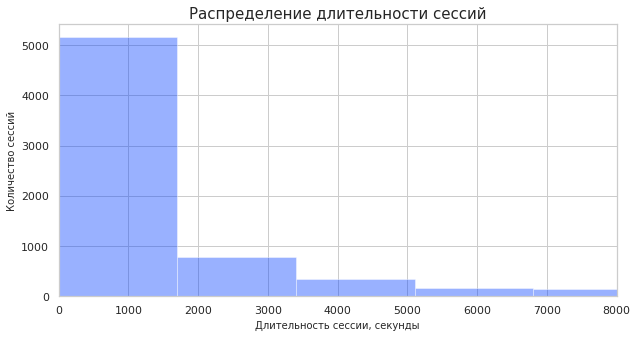

In [31]:
# Визуализируем распределение данных о длительности сессий

plt.figure(figsize=(10, 5))
sns.set(style='whitegrid', palette='bright')
ax = sns.distplot(session_duration['session_duration'], kde=False)
ax.set(xlim=(0, 8000))
plt.title('Распределение длительности сессий', fontsize=15)
plt.ylabel('Количество сессий', fontsize=10)
plt.xlabel('Длительность сессии, секунды', fontsize=10)
plt.show()

In [32]:
# Смотрим информацию о минимальных значениях длительности сессий

display(session_duration[session_duration['session_duration'] == 0]\
        .groupby('event_date')['session_duration']\
        .count()\
        .describe())

count   28.000
mean    33.821
std     10.350
min     11.000
25%     25.000
50%     37.500
75%     41.000
max     52.000
Name: session_duration, dtype: float64

In [33]:
# Смотрим информацию о максимальных значениях длительности сессий

display(session_duration[session_duration['session_duration'] > 7092]\
        .groupby('event_date')['session_duration']\
        .count()\
        .describe())

count   28.000
mean    45.964
std     12.103
min     19.000
25%     39.500
50%     46.500
75%     53.500
max     67.000
Name: session_duration, dtype: float64

**Выводы**: В течении изучаемого периода времени пользователи осуществили 7 817 сессий, средняя длительность сессии составила 4 982 секунды, или 83 минуты
минимальная сессия равна 0; распределение нулевых сессий по дням достаточно равномерное и не имеет аномалий; 
50% сессий равна 708 секундам, или 12 минутам.

### Анализ конверсии в целевое действие

In [34]:
# Соберем табличку по пользователям, осуществившим какие-то действия, уберем tips_show

data_users = data_merged.pivot_table(index = ["user_id", "source"], columns = 'event_name', values = 'event_time', aggfunc = ('count'))\
.drop('tips_show', axis=1)
display(data_users.head(2))


,event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click
user_id,source,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,NaN,NaN,NaN,NaN,6.000,NaN,NaN,NaN
00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2.000,5.000,11.000,2.000,NaN,33.000,18.000,NaN


In [35]:
# Смотрим информацию по кол-ву действий пользователей, осуществивших целевое действие

display(data_users.describe().T.sort_values(by='count', ascending=False))

,count,mean,std,min,25%,50%,75%,max
event_name,,,,,,,,
search,1658.000,4.087,5.170,1.000,2.000,3.000,4.000,68.000
map,1440.000,2.684,4.774,1.000,1.000,1.000,3.000,71.000
photos_show,1091.000,9.173,14.633,1.000,3.000,5.000,9.000,177.000
contacts_show,975.000,4.639,9.647,1.000,1.000,2.000,4.000,137.000
advert_open,750.000,8.217,12.705,1.000,2.000,4.000,8.750,137.000
favorites_add,351.000,4.037,6.292,1.000,1.000,2.000,5.000,63.000
tips_click,322.000,2.528,2.943,1.000,1.000,1.000,3.000,30.000
contacts_call,213.000,2.540,2.388,1.000,1.000,2.000,3.000,17.000


In [36]:
# Смотрим распределение целевого действия по уникальным пользователям

display(data_users['contacts_show']\
        .value_counts()\
        .to_frame()\
        .reset_index()\
        .rename(columns={'index':'кол-во просмотров', 'contacts_show':'кол-во пользователей'})
        .sort_values(by='кол-во просмотров', ascending=False).T)

,36,39,32,34,30,33,27,26,28,29,22,24,37,38,35,...,13,15,14,10,8,12,9,7,6,5,4,3,2,1,0
кол-во просмотров,137.000,100.000,86.000,83.000,74.000,69.000,68.000,65.000,62.000,61.000,60.000,43.000,39.000,32.000,29.000,...,15.000,14.000,13.000,12.000,11.000,10.000,9.000,8.000,7.000,6.000,5.000,4.000,3.000,2.000,1.000
кол-во пользователей,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.000,1.000,1.000,1.000,1.000,...,4.000,4.000,4.000,13.000,17.000,5.000,16.000,19.000,33.000,38.000,46.000,71.000,106.000,183.000,374.000


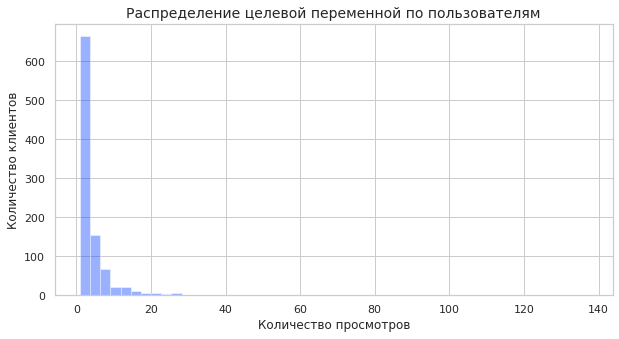

In [37]:
# Визуализируем данные

plt.figure(figsize=(10, 5))
sns.distplot(data_users['contacts_show'], kde=False)
plt.title('Распределение целевой переменной по пользователям', fontsize=14)
plt.xlabel('Количество просмотров', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.show()

In [38]:
conv_1 = data_merged.query('event_name == "contacts_show"')
conv_1 = conv_1['user_id'].nunique()/ data_merged['user_id'].nunique()
conv_1

0.23060548722800378

**Выводы**: Распределение данных имеет ассиметричный характер, скошено вправо, 
75% клиентов осуществили целевое действие от 1 до 4 раз. 
Обнаружены аномальные выбросы, максимальное количество целевых действий, осуществленных одним клиентом - 137 раз.


## Сегментация пользователей на основе их действий в приложении. 

### Разделение пользователей на кластеры

Стоит сегментировать пользователей по ключевым метрикам, таким как количество сессий, целевое действие, просмотр фото, добавление объявлений в избранное, использование поиска.

In [39]:
# Добавим в метрику data_users данные о количестве сессий

data_users= data_users.merge(session_count, on='user_id')
data_users.head()


,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,session_duration
user_id,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,NaN,NaN,NaN,NaN,6.000,NaN,NaN,NaN,4
00157779-810c-4498-9e05-a1e9e3cedf93,2.000,5.000,11.000,2.000,NaN,33.000,18.000,NaN,6
00463033-5717-4bf1-91b4-09183923b9df,NaN,NaN,NaN,NaN,NaN,10.000,NaN,NaN,1
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5.000,NaN,NaN,NaN,6.000,NaN,17.000,NaN,6
00551e79-152e-4441-9cf7-565d7eb04090,NaN,3.000,3.000,NaN,NaN,1.000,1.000,NaN,3


In [40]:
#Убираем NaN которые могут помешать кластеризации
data_users = data_users.fillna(0)
data_users.head()


,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,session_duration
user_id,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.000,0.000,0.000,0.000,6.000,0.000,0.000,0.000,4
00157779-810c-4498-9e05-a1e9e3cedf93,2.000,5.000,11.000,2.000,0.000,33.000,18.000,0.000,6
00463033-5717-4bf1-91b4-09183923b9df,0.000,0.000,0.000,0.000,0.000,10.000,0.000,0.000,1
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5.000,0.000,0.000,0.000,6.000,0.000,17.000,0.000,6
00551e79-152e-4441-9cf7-565d7eb04090,0.000,3.000,3.000,0.000,0.000,1.000,1.000,0.000,3


In [41]:
# Убираем выбросы
data_users = data_users.query('session_duration<7')

In [42]:
sc = StandardScaler()
X_sc = sc.fit_transform(data_users)
linked = linkage(X_sc, method = 'ward')

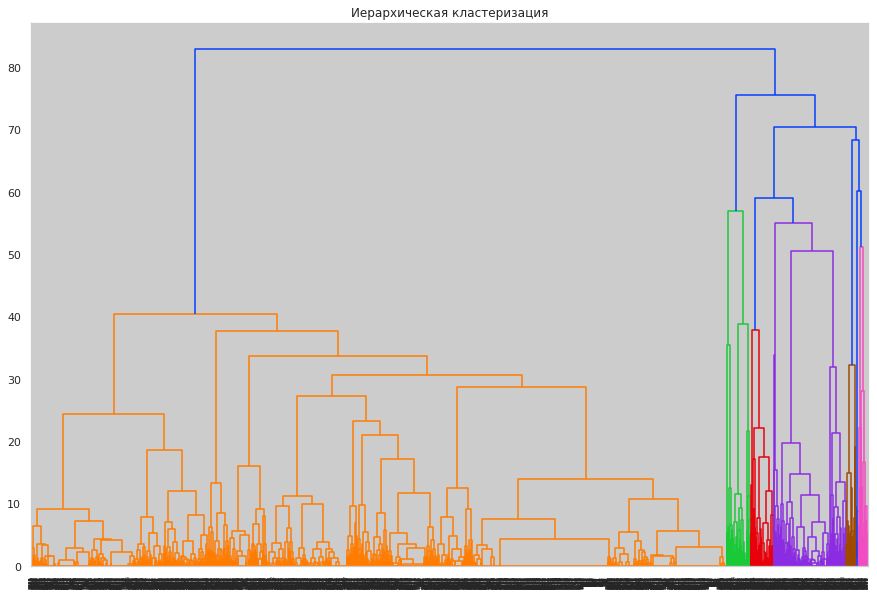

In [43]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

In [44]:
# задаём минимальное число кластеров
km = KMeans(n_clusters = 2, random_state=42) 

#применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(X_sc) 

#добавляем метки кластеров в данные
data_users['claster'] = labels

In [45]:
data_users = data_users.reset_index()
data_users.head()

,user_id,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,session_duration,claster
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.000,0.000,0.000,0.000,6.000,0.000,0.000,0.000,4,1
1,00157779-810c-4498-9e05-a1e9e3cedf93,2.000,5.000,11.000,2.000,0.000,33.000,18.000,0.000,6,1
2,00463033-5717-4bf1-91b4-09183923b9df,0.000,0.000,0.000,0.000,0.000,10.000,0.000,0.000,1,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5.000,0.000,0.000,0.000,6.000,0.000,17.000,0.000,6,1
4,00551e79-152e-4441-9cf7-565d7eb04090,0.000,3.000,3.000,0.000,0.000,1.000,1.000,0.000,3,1


In [46]:
#Группируем по кластерам и событиям
data_users.groupby('claster').mean().T

claster,0,1
advert_open,0.834,4.613
contacts_call,0.033,0.718
contacts_show,0.421,3.774
favorites_add,0.137,1.438
map,0.683,1.577
photos_show,1.376,6.008
search,1.052,3.879
tips_click,0.102,0.690
session_duration,1.340,3.583


In [47]:
# Подсчитываем количество пользователей в каждой группе, для проверки распределения 

data_users.groupby('claster')['user_id'].nunique()

claster
0    3611
1     504
Name: user_id, dtype: int64

**Вывод**: В итоге сегментации удалось выделить два достаточно крупных кластера. 

**Кластер 0** Самый большой по количеству пользователей, но далеко не самый активный. Данные пользователи очень вяло совершают действия в приложении;  мало просматривают контакты продавцов (наша целевая метрика), плохо просматривают фото. Да и поиском они пользуются в три раза реже. Единственное событие, которое совершается чаще - это кликают по  рекомендованным объявлениям. 

**Кластер 1** По количеству пользователей он меньше почти в 7 раз. Но по всем показателям, пользователи в нем намного активнее. Пользователи намного дольше сидят в приложении, активно смотрят фото, пользуются поиском и очень часто совершают целевое действие, правда меньше отвлекаясь на рекомендованные объявления. Я бы сказала, что именно этот кластер - целевой. 

### Расчет Retention rate по кластерам

In [48]:
# Добавим распределение по кластерам дляя выделения по ним коэффициента удержания и конверсии
user_claster = data_users.drop(['advert_open', 'contacts_call', 'contacts_show', 'favorites_add', 'map', 'photos_show', 'search', 'tips_click', 'session_duration'], 1)
data_merged = data_merged.merge(user_claster, on='user_id')
data_merged.head()

,event_time,user_id,source,dt,event_name,event_date,week_day,claster
0,2019-10-07 00:00:00,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,advert_open,2019-10-07,0,0
1,2019-10-07 00:00:01,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,tips_show,2019-10-07,0,0
2,2019-10-07 00:00:07,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,tips_show,2019-10-07,0,0
3,2019-10-07 00:01:28,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,advert_open,2019-10-07,0,0
4,2019-10-07 00:01:35,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,tips_show,2019-10-07,0,0


In [49]:
# Разделим пользователей на две части по кластерам
claster_0 = data_merged.query('claster == 0')
claster_1 = data_merged.query('claster == 1')


In [50]:
claster_0.head()

,event_time,user_id,source,dt,event_name,event_date,week_day,claster
0,2019-10-07 00:00:00,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,advert_open,2019-10-07,0,0
1,2019-10-07 00:00:01,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,tips_show,2019-10-07,0,0
2,2019-10-07 00:00:07,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,tips_show,2019-10-07,0,0
3,2019-10-07 00:01:28,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,advert_open,2019-10-07,0,0
4,2019-10-07 00:01:35,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,tips_show,2019-10-07,0,0


In [51]:
# Нужно уточнить событие и период, в течение которого оно было совершено — на основе активности пользователей в приложении сформируем группы. 
#Возьмём дату, когда пользователь впервые проявил активность в мобильном приложении, (минимальная дата).
min_date_0 = claster_0.groupby(['user_id'])['event_date'].min()
min_date_0.name = 'min_date'
user_activity_0 = claster_0.join(min_date_0,on='user_id')

In [52]:
#У нас получился день начала недели, за которую произошло событие. Он станет идентификатором недели. 
#Метод pd.to_timedelta задаёт единицу измерения, нам нужен день: unit='d'. Вычтем из даты порядковый номер дня:
user_activity_0['activity_week'] = pd.to_datetime(user_activity_0['event_date'],
                                                unit='d') - pd.to_timedelta(user_activity_0['event_date'].dt.dayofweek, unit='d')
user_activity_0['primary_activity_week'] = pd.to_datetime(user_activity_0['min_date'],
                                                      unit='d') - pd.to_timedelta(user_activity_0['min_date'].dt.dayofweek, unit='d')

In [53]:
# Для каждой строки таблицы рассчитаем сколько времени провоит пользователь в приложении в рамках группы
user_activity_0['group_lifetime'] = user_activity_0['activity_week'] - user_activity_0['primary_activity_week']
user_activity_0['group_lifetime'] = user_activity_0['group_lifetime'] / np.timedelta64(1,'W')
user_activity_0['group_lifetime'] = user_activity_0['group_lifetime'].astype(int)

In [54]:
# Сгруппируем данные по группе и lifetime. 
#Посчитаем для каждой группы количество активных пользователей на определённую неделю 
groups_0 = user_activity_0.groupby(['primary_activity_week','group_lifetime']).agg({'user_id':'nunique'}).reset_index()

Для расчета Retention Rate, нужно для начала посчитать количество пользователей, изначально бывших в группе, и на него разделить количества пользователей в каждую следующую неделю, так мы получим коэффициент удержания клиентов, т.е. сколько из них осталось

In [55]:
# Найдём исходное количество пользователей в группе. Возьмём их число на нулевую неделю:
first_users_0 = groups_0[groups_0['group_lifetime'] == 0][['primary_activity_week','user_id']]
first_users_0 = first_users_0.rename(columns={'user_id':'group_users'})
groups_0 = groups_0.merge(first_users_0,on='primary_activity_week')

In [56]:
# Расчет коэффициента удержания
groups_0['retention'] = groups_0['user_id']/groups_0['group_users']

In [57]:
retention_rate_0 = groups_0.pivot_table(index='primary_activity_week',columns='group_lifetime',values='retention',aggfunc='sum')

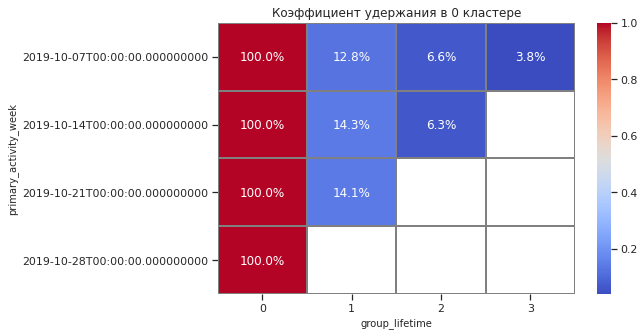

In [58]:
# Визуализируем полученные данные
sns.set(style='ticks')
plt.figure(figsize=(8, 5))
plt.title('Коэффициент удержания в 0 кластере')
plt.ylabel('Количество активных пользователей в 0 кластере', fontsize=10)
plt.xlabel('Нулевая неделя', fontsize=10)
sns.heatmap(retention_rate_0, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap= 'coolwarm');

Теперь повторим алгоритм для кластера №1

In [59]:
min_date_1 = claster_1.groupby(['user_id'])['event_date'].min()
min_date_1.name = 'min_date'
user_activity_1 = claster_1.join(min_date_1,on='user_id')

In [60]:
user_activity_1['activity_week'] = pd.to_datetime(user_activity_1['event_date'],
                                                unit='d') - pd.to_timedelta(user_activity_1['event_date'].dt.dayofweek, unit='d')
user_activity_1['primary_activity_week'] = pd.to_datetime(user_activity_1['min_date'],
                                                      unit='d') - pd.to_timedelta(user_activity_1['min_date'].dt.dayofweek, unit='d')

In [61]:
user_activity_1['group_lifetime'] = user_activity_1['activity_week'] - user_activity_1['primary_activity_week']
user_activity_1['group_lifetime'] = user_activity_1['group_lifetime'] / np.timedelta64(1,'W')
user_activity_1['group_lifetime'] = user_activity_1['group_lifetime'].astype(int)

In [62]:
groups_1 = user_activity_1.groupby(['primary_activity_week','group_lifetime']).agg({'user_id':'nunique'}).reset_index()
first_users_1 = groups_1[groups_1['group_lifetime'] == 0][['primary_activity_week','user_id']]
first_users_1 = first_users_1.rename(columns={'user_id':'group_users'})
groups_1 = groups_1.merge(first_users_1,on='primary_activity_week')

In [63]:
groups_1['retention'] = groups_1['user_id']/groups_1['group_users']
retention_rate_1 = groups_1.pivot_table(index='primary_activity_week',columns='group_lifetime',values='retention',aggfunc='sum')

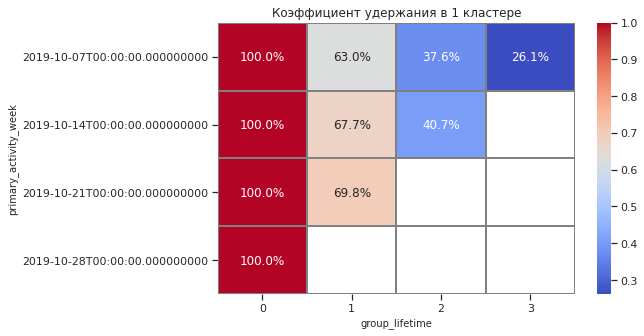

In [64]:
# Визуализируем полученные данные
sns.set(style='ticks')
plt.figure(figsize=(8, 5))
plt.title('Коэффициент удержания в 1 кластере')
plt.ylabel('Количество активных пользователей в 1 кластере', fontsize=10)
plt.xlabel('Нулевая неделя', fontsize=10)
sns.heatmap(retention_rate_1, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap= 'coolwarm');

**Вывод**: Коэффициент удержания в первую неделю убывает по группам с течением времени, это справедливо для обоих кластеров. Но кластер №0 демонстрирует гораздо более низкий процент удержания. К примеру, если для группы пользователей 0 кластера, пришедших с 7 октября по 13 октября коэффициент удержания в первую неделю составляет 12,8%, то для пользователей кластера №1, пришедших в то же самое время, коэффициент уже намного выше, целых 63%. С каждой новой группой поведение пользователей меняется. Соответственно, чем больше группа проводит времени в приложении, тем меньше пользователей остается. Но к концу периода исследования, Retention rate в 0 кластере всего 3,8%, в то время как кластер 1 демонстрирует очень приличные 26,1% в 8! раз выше 0 кластера.

### Расчет конверсии по кластерам

In [65]:
conv_0 = claster_0.query('event_name == "contacts_show"')
conv_0 = conv_0['user_id'].nunique()/ claster_0['user_id'].nunique()
conv_0

0.17806701744669068

In [66]:
conv_1 = claster_1.query('event_name == "contacts_show"')
conv_1 = conv_1['user_id'].nunique()/ claster_1['user_id'].nunique()
conv_1

0.5277777777777778

**Вывод**: Кластер 0 также демонстрирует худшие результаты и в плане конверсии, 17,8% - это конечно неплохо, но у 1 кластера показатели в 2,5 раза больше - целых 52,7%

## Проверка статистических гипотез

### Гипотеза №1: Группы Yandex и Google демонстрируют разную конверсию в просмотры контактов.

Для начала, сформулируем нулевую и альтернативную гипотезы:

Н0: Группы Yandex и Google не демонстрируют статистически важных различий конверсии в просмотры контактов

Н1: Группы Yandex и Google демонстрируют разную конверсию в просмотры контактов

Сформируем таблицу и проверим гипотезу о наличии статистически значимой разницы с помощью z-критерия:

In [67]:
yandex = data_merged.query('source =="yandex" and event_name == "contacts_show"')
google = data_merged.query('source =="google" and event_name == "contacts_show"')

In [68]:
source_users_count = data_merged.query('source !="other"').groupby('source')['user_id'].nunique()

In [69]:
users_by_events = data_merged.query('event_name == "contacts_show" and source !="other"').pivot_table(index='source',columns='event_name', values='user_id', aggfunc='nunique').reset_index()
users_by_events
users_by_events['user_count'] = users_by_events['source'].apply(lambda x: source_users_count.loc[x])
users_by_events = users_by_events.set_index('source')
users_by_events.columns = ['contacts_show', 'user_count']

In [70]:
users_by_events

,contacts_show,user_count
source,,
google,249,1082
yandex,452,1861


In [71]:
# статистическое сравнение долей 

alpha = 0.05

stat, pval = proportions_ztest(np.array([users_by_events.loc['google', 'contacts_show'], 
                                         users_by_events.loc['yandex', 'contacts_show']]), 
                               np.array([users_by_events.loc['google', 'user_count'], 
                                         users_by_events.loc['yandex', 'user_count']]))
print('{0:0.3f}'.format(pval))

if (pval < alpha): 
        print("Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия.")
else:
        print("Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет.")

0.434
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет.


**Вывод**: С высокой вероятностью между пользователями, установившими приложение из разных источников, нет значимой разницы. Можно сделать вывод, что источник установки на конверсию не влияет.

### Гипотеза №2: конверсия в просмотры контактов различается у пользователей, которые добавляют объявления в закладки, от тех кто не добавляет.

Также сформулируем нулевую и альтернативную гипотезы:

Н0: Конверсия в просмотры контактов между теми пользователями, которые добавляют объявления в закладки, от тех кто не добавляет, не демонстрируют статистически важных различий конверсии в просмотры контактов

Н1:Конверсия в просмотры контактов между теми пользователями, которые добавляют объявления в закладки, от тех кто не добавляет, демонстрируют разную конверсию в просмотры контактов

In [72]:
all_users= data_merged['user_id'].unique()
print('Количество уникальных пользователей:', len(all_users))
 
# Выделяем пользователей, добавляющих объявление в закладки
a_group=data_merged.query('event_name=="favorites_add"')['user_id'].unique()
print('Количество пользователей в группе A:', len(a_group))

# Выделяем пользователей, не добавляющих объявление в закладки
b_group = list(set(all_users) - set(a_group))
print('Количество пользователей в группе В :', len(b_group))

Количество уникальных пользователей: 4115
Количество пользователей в группе A: 322
Количество пользователей в группе В : 3793


In [73]:
# Вычисляем сколько всего действий у обеих групп
user_fav_add = data_merged.query('user_id in @a_group')[['user_id','event_name']]
user_no_fav_add= data_merged.query('user_id in @b_group')[['user_id','event_name']]


print('Количество пользователей в группе А, совершивших целевое действие :', user_fav_add.query('event_name=="contacts_show"')['user_id'].nunique())
print('Количество пользователей в группе В, совершивших целевое действие: ', user_no_fav_add.query('event_name=="contacts_show"')['user_id'].nunique())


Количество пользователей в группе А, совершивших целевое действие : 122
Количество пользователей в группе В, совершивших целевое действие:  787


In [74]:
#Для проверки конверсий применим  Z-критерий:

def z_test(successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    
    print(successes1, successes2, trials1, trials2)
    
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) 
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2 
    print('p-значение: ', p_value)
 
    if (p_value < alpha): 
        display('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
    else:
        display('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')
z_test(136,839,351,3877, alpha=0.05)  

136 839 351 3877
p-значение:  3.199662756969701e-13


'Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия'

**Вывод**: С высокой вероятностью между пользователями, добавляющими объявления в закладки и между теми, кто этого не делает - есть существенная разница. Можно сделать вывод, что добавление объявления в избранное влияет на конверсию.

## Общие выводы

**Вывод**
Задачи проекта:

- Проанализировать связь целевого события — просмотра контактов — и других действий пользователей.
- Оценить, какие действия чаще совершают те пользователи, которые просматривают контакты.
- Провести исследовательский анализ данных
- Проанализировать влияние событий на совершение целевого события
- Сегментировать пользователей на группы в зависимости от их действий в приложении
- Проверить статистические гипотезы

В ходе предобработки данных были проанализированы данные в период  с 2019-10-07 по 2019-11-03.
Названия столбцов были приведены к правильному синтаксису, поработали над форматом даты в столбце event_date, дубликатов и пропущенных значений не было обнаружено.
Действие show_contacts объединили с действием contacts_show в один столбец, так как это одно действие. Также 7 типов поиска были объединены в один.
События по всему периоду сбора данных распределены равномерно, аномальных выбросов не обнаружено.  Итого 65 пользователей совершили всего одно действие, среднее количество действий - 17, медианное - 9, самые активные пользователи приложения совершили более 60 действий. Также отмечено, что количество событий пользователя и количество различных действий отличаются. Мы исключили пользователей всего с одним действием, как несущественных для проведения анализа. Также мы убрали tips_show - это автоматическое действие, оно нам не нужно. Самые часто совершаемые действия: map - 1 456 клиент открыл карту объявлений photos_show - 1 095 клиентов просмотрели фотографии в объявлениях contacts_show - 981 клиент просмотрел контакты, т.е. совершил целевое действие search_1 - 787 клиентов осуществили поиск  Также мы выяснили, что пользователи, пришедшие с поисковой системы Яндекс, устанавливают приложение чаще.

 В итоге сегментации удалось выделить два достаточно крупных кластера. 

**Кластер 0** Самый большой по количеству пользователей, но далеко не самый активный. Данные пользователи очень вяло совершают действия в приложении;  мало просматривают контакты продавцов (наша целевая метрика), плохо просматривают фото. Да и поиском они пользуются в три раза реже. Единственное событие, которое совершается чаще - это кликают по  рекомендованным объявлениям. 

**Кластер 1** По количеству пользователей он меньше почти в 7 раз. Но по всем показателям, пользователи в нем намного активнее. Пользователи намного дольше сидят в приложении, активно смотрят фото, пользуются поиском и очень часто совершают целевое действие, правда меньше отвлекаясь на рекомендованные объявления. Я бы сказала, что именно этот кластер - целевой. 

Была расчитана метрика Retention Rate (коэффициент удержания) по обоим кластерам отдельно. Коэффициент удержания в первую неделю убывает по группам с течением времени, это справедливо для обоих кластеров. Но кластер №0 демонстрирует гораздо более низкий процент удержания. К примеру, если для группы пользователей 0 кластера, пришедших с 7 октября по 13 октября коэффициент удержания в первую неделю составляет 12,8%, то для пользователей кластера №1, пришедших в то же самое время, коэффициент уже намного выше, целых 63%. С каждой новой группой поведение пользователей меняется. Соответственно, чем больше группа проводит времени в приложении, тем меньше пользователей остается. Но к концу периода исследования, Retention rate в 0 кластере всего 3,8%, в то время как кластер 1 демонстрирует очень приличные 26,1% в 8! раз выше 0 кластера.


При проверке гипотез, выявили, что канал установки приложения не имеет статистической значимости. А вот конверсия тех, кто добавляет объявления в избранное, намного выше. Это же было подтверждено кластеризацией и пользователями 1-го кластера.

Судя по анализу и расчетам, пользователи плохо удерживаются в приложении, возможно нужно доработать интерфейс приложения, подавляющее большинство пользователей совершают очень мало действий, не открывают фото, рекламу, плохо пользуются поиском... возможно приложение их никак не заинтересовало. Стоит тщательнее подбирать рекомендованные объявления, определять геопозицию пользователя, пользоваться услугами таргетологов, чтобы предлагать только интересные для пользователя объявления.

Для увеличения конверсии, возможно стоит доработать интерфейс так, чтобы удобнее было добавлять объявления в избранное и удобнее пользоваться папкой "Избранное", тк это тоже существенно влияет на конверсию в целевые действия. 